# Variable Preprocessing

In [1]:
# install required libraries
# !pip install xarray netCDF4 h5netcdf numpy rioxarray regionmask geopandas

In [2]:
import xarray as xr
import numpy as np
import geopandas as gpd
import regionmask

### Load ERA5-Land and ERA5 data

In [3]:
era5land = xr.open_dataset('era5-land_2019.nc') # open ERA5-Land NetCDF file
print(era5land) # view structure
print("\n--------------------------------------------------------------------------------\n")

era5 = xr.open_dataset("era5_2019.nc") # open ERA5 NetCEF file
print(era5) # view structure

<xarray.Dataset> Size: 180MB
Dimensions:     (valid_time: 744, latitude: 96, longitude: 105)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 6kB 2019-08-01 ... 2019-08-31T23:...
  * latitude    (latitude) float64 768B 42.0 41.9 41.8 41.7 ... 32.7 32.6 32.5
  * longitude   (longitude) float64 840B -124.5 -124.4 -124.3 ... -114.2 -114.1
    number      int64 8B ...
    expver      (valid_time) <U4 12kB ...
Data variables:
    d2m         (valid_time, latitude, longitude) float32 30MB ...
    t2m         (valid_time, latitude, longitude) float32 30MB ...
    ssrd        (valid_time, latitude, longitude) float32 30MB ...
    u10         (valid_time, latitude, longitude) float32 30MB ...
    v10         (valid_time, latitude, longitude) float32 30MB ...
    sp          (valid_time, latitude, longitude) float32 30MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conv

### Convert varaible units

In [4]:
# convert t2m from K to Celsius -- used as "Tair" input
t2m_c = era5land["t2m"] - 273.15
t2m_c.attrs["units"] = "C"

# convert d2m from K to Celsius -- used in "relhum" calculation
d2m_c = era5land["d2m"] - 273.15
d2m_c.attrs["units"] = "C"

# convert ssrd from J/m2 to W/m2 -- used as "solar" input
era5land["ssrd"].valid_time.diff("time") # check that time resolution is hourly
ssrd_W = era5land["ssrd"] / 3600         # dividy by 3600 seconds since hourly accumulated
ssrd_W.attrs["units"] = "W m**-2"

# convert sp from Pa to hPa -- used as "pres" input
sp_hpa = era5land["sp"] / 100
sp_hpa.attrs["units"] = "hPa"

### Calculate derived variables

In [5]:
# calculate relative humidity (%) -- used as "relhum" input
vapor_pres = 610.94*np.exp(17.625*d2m_c / (243.04+d2m_c))
sat_vapor_pres = 610.94*np.exp(17.625*t2m_c / (243.04+t2m_c))
rh = 100*(vapor_pres/sat_vapor_pres)
rh.attrs["long_name"] = "relative humidity (%)"
rh.attrs["units"] = "%"

# calculate wind speed (m/s) -- used as "speed" input
u = era5land["u10"]
v = era5land["v10"]
ws = np.sqrt(u**2 + v**2)
ws.attrs["long_name"] = "wind speed (m/s)"
ws.attrs["units"] = "m s**-1"

In [6]:
# load interpolated ERA5 fdir nc file
era5_fdir_idw = xr.open_dataset('era5_fdir_idw_2019.nc') 
print(era5_fdir_idw)

<xarray.Dataset> Size: 30MB
Dimensions:    (time: 744, latitude: 96, longitude: 105)
Coordinates:
  * time       (time) datetime64[ns] 6kB 2019-08-01 ... 2019-08-31T23:00:00
  * latitude   (latitude) float64 768B 42.0 41.9 41.8 41.7 ... 32.7 32.6 32.5
  * longitude  (longitude) float64 840B -124.5 -124.4 -124.3 ... -114.2 -114.1
Data variables:
    fdir       (time, latitude, longitude) float32 30MB ...
Attributes:
    source:         ERA5
    target_grid:    era5land_d2m_2019-08-01T00.tif
    interpolation:  IDW (k=8, power=2.0) in lon/lat degree space
    crs:            EPSG:4326


In [7]:
# calculate fraction of surface solar radiation that is direct (0-1) -- used as "fdir" input

#print(era5_fdir_idw["fdir"].attrs.get("units"))
#print(era5land["ssrd"].attrs.get("units"))       # check that numerator and denomator are of the same units

# fraction calculated as fdir/ssrd, nan if ssrd is nan, 0 if ssrd is 0
fdir = xr.where(era5land["ssrd"].isnull(), np.nan, 
                xr.where(era5land["ssrd"] > 0, era5_fdir_idw["fdir"].values / era5land["ssrd"].values, 0.0))
fdir.attrs["long_name"] = "fraction of surface solar radiation that is direct (0-1)"
fdir.attrs["units"] = ""  # no units

### Obtain and derive "urban" variable

In [8]:
# from National Land Cover Database

In [9]:
# load urban_variable.nc that was created in QGIS
urban = xr.open_dataset('urban_variable.nc') 
urban = urban.rename({'Band1': 'urban'})
urban['urban'] = urban['urban'].astype('int8')
urban = urban.rename({"lat": "latitude", "lon": "longitude"})
urban = urban.sortby("latitude", ascending=False)
urban = urban.expand_dims(valid_time = era5land.valid_time)
urban["urban"].attrs["long_name"] = "urban (1), rural (0)"
urban["urban"].attrs["units"] = ""
urban = urban.assign_coords(latitude = ssrd_W.latitude, longitude = ssrd_W.longitude)
print(urban)

<xarray.Dataset> Size: 8MB
Dimensions:     (valid_time: 744, latitude: 96, longitude: 105)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 6kB 2019-08-01 ... 2019-08-31T23:...
  * latitude    (latitude) float64 768B 42.0 41.9 41.8 41.7 ... 32.7 32.6 32.5
  * longitude   (longitude) float64 840B -124.5 -124.4 -124.3 ... -114.2 -114.1
    number      int64 8B 0
Data variables:
    urban       (valid_time, latitude, longitude) int8 7MB 0 0 0 0 0 ... 0 0 0 0
    crs         (valid_time) |S1 744B b'' b'' b'' b'' b'' ... b'' b'' b'' b''
Attributes:
    Conventions:  CF-1.5
    GDAL:         GDAL 3.12.1 "Chicoutimi", released 2025/12/12
    history:      Thu Feb 05 13:45:01 2026: GDAL Create( C:\Users\new account...


C:\Users\new account\AppData\Local\Programs\Python\Python312\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


### Build a working dataset (ds_work) containing WBGT input variables
xr.Dataset creates a dataset resembling an in-memory representation of a NetCDF file. Consists of variables, coordinates, and attributes, which together form a self-describing dataset.

In [10]:
# check resolution of variables before putting into working dataset

print(abs(ssrd_W.latitude[1] - ssrd_W.latitude[0]).values)
print(abs(fdir.latitude[1] - fdir.latitude[0]).values)
print(abs(sp_hpa.latitude[1] - sp_hpa.latitude[0]).values)
print(abs(t2m_c.latitude[1] - t2m_c.latitude[0]).values)
print(abs(rh.latitude[1] - rh.latitude[0]).values)
print(abs(ws.latitude[1] - ws.latitude[0]).values)
print(abs(urban["urban"].latitude[1] - urban["urban"].latitude[0]).values)

0.10000000000000142
0.10000000000000142
0.10000000000000142
0.10000000000000142
0.10000000000000142
0.10000000000000142
0.10000000000000142


In [11]:
# zspeed = 10 m and dt = −0.052 C don't need to be in ds_work since they are fixed parameters (don't change through space and time)
# They can be inputted into the WBGT function as constants.

# cza input will be calculated using the calc_cza_int(lat, lon, y, mon, d, hr) function in the heatmetrics R package
# idea: get coordinate inputs for calc_cza_int function from ds_work, expand them to full grid, input into calc_cza_int

ds_work = xr.Dataset(
    {"solar": ssrd_W,
     "fdir": fdir,
     "pres": sp_hpa,
     "Tair": t2m_c,
     "relhum": rh,
     "speed": ws,
     "urban": urban["urban"]
    }
    )
ds_work = ds_work.sortby("latitude", ascending=False)

# Create needed coordinates
time = ds_work.valid_time
ds_work = ds_work.assign_coords(
    year = time.dt.year,
    month = time.dt.month,
    day=time.dt.day,
    hour=time.dt.hour,
    # decimal day of month (UTC)
    dday = (time.dt.day
            + time.dt.hour / 24
            + time.dt.minute / 1440
            + time.dt.second / 86400))

print(ds_work)  # view structure

<xarray.Dataset> Size: 188MB
Dimensions:     (valid_time: 744, latitude: 96, longitude: 105)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 6kB 2019-08-01 ... 2019-08-31T23:...
  * latitude    (latitude) float64 768B 42.0 41.9 41.8 41.7 ... 32.7 32.6 32.5
  * longitude   (longitude) float64 840B -124.5 -124.4 -124.3 ... -114.2 -114.1
    number      int64 8B 0
    expver      (valid_time) <U4 12kB '0001' '0001' '0001' ... '0001' '0001'
    year        (valid_time) int64 6kB 2019 2019 2019 2019 ... 2019 2019 2019
    month       (valid_time) int64 6kB 8 8 8 8 8 8 8 8 8 8 ... 8 8 8 8 8 8 8 8 8
    day         (valid_time) int64 6kB 1 1 1 1 1 1 1 1 ... 31 31 31 31 31 31 31
    hour        (valid_time) int64 6kB 0 1 2 3 4 5 6 7 ... 17 18 19 20 21 22 23
    dday        (valid_time) float64 6kB 1.0 1.042 1.083 ... 31.88 31.92 31.96
Data variables:
    solar       (valid_time, latitude, longitude) float32 30MB nan ... 6.541e+03
    fdir        (valid_time, latitude, longitude) float

In [12]:
# check long name and units of preprocessed variables
print("solar", ds_work["solar"].attrs["long_name"], ds_work["solar"].attrs["units"])
print("fdir", ds_work["fdir"].attrs["long_name"], ds_work["fdir"].attrs["units"])
print("pres", ds_work["pres"].attrs["long_name"], ds_work["pres"].attrs["units"])
print("Tair", ds_work["Tair"].attrs["long_name"], ds_work["Tair"].attrs["units"])
print("relhum", ds_work["relhum"].attrs["long_name"], ds_work["relhum"].attrs["units"])
print("speed", ds_work["speed"].attrs["long_name"], ds_work["speed"].attrs["units"])
print("urban", ds_work["urban"].attrs["long_name"], ds_work["urban"].attrs["units"])

solar Surface short-wave (solar) radiation downwards W m**-2
fdir fraction of surface solar radiation that is direct (0-1) 
pres Surface pressure hPa
Tair 2 metre temperature C
relhum relative humidity (%) %
speed wind speed (m/s) m s**-1
urban urban (1), rural (0) 


### Clip ds_work to California boundary

In [13]:
ca = gpd.read_file("ca_state/CA_state.shp")
ca = ca.to_crs("EPSG:4326")
mask = regionmask.mask_geopandas(ca, ds_work.longitude, ds_work.latitude)
ds_work = ds_work.where(~mask.isnull()) # keep whole grid cells

In [14]:
print(ds_work)

<xarray.Dataset> Size: 210MB
Dimensions:     (valid_time: 744, latitude: 96, longitude: 105)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 6kB 2019-08-01 ... 2019-08-31T23:...
  * latitude    (latitude) float64 768B 42.0 41.9 41.8 41.7 ... 32.7 32.6 32.5
  * longitude   (longitude) float64 840B -124.5 -124.4 -124.3 ... -114.2 -114.1
    number      int64 8B 0
    expver      (valid_time) <U4 12kB '0001' '0001' '0001' ... '0001' '0001'
    year        (valid_time) int64 6kB 2019 2019 2019 2019 ... 2019 2019 2019
    month       (valid_time) int64 6kB 8 8 8 8 8 8 8 8 8 8 ... 8 8 8 8 8 8 8 8 8
    day         (valid_time) int64 6kB 1 1 1 1 1 1 1 1 ... 31 31 31 31 31 31 31
    hour        (valid_time) int64 6kB 0 1 2 3 4 5 6 7 ... 17 18 19 20 21 22 23
    dday        (valid_time) float64 6kB 1.0 1.042 1.083 ... 31.88 31.92 31.96
Data variables:
    solar       (valid_time, latitude, longitude) float32 30MB nan nan ... nan
    fdir        (valid_time, latitude, longitude) float32

### Export ds_work.nc as a file

In [15]:
# export ds_work as a netCDF file
# ds_work.to_netcdf("ds_work.nc")

### View values of preprocessed variables

In [16]:
# plotting variables at a single valid_time

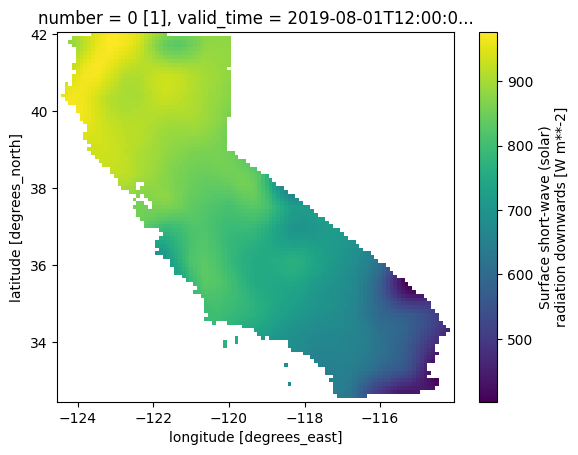

In [17]:
ds_work["solar"].sel(valid_time="2019-08-01T12:00").plot()

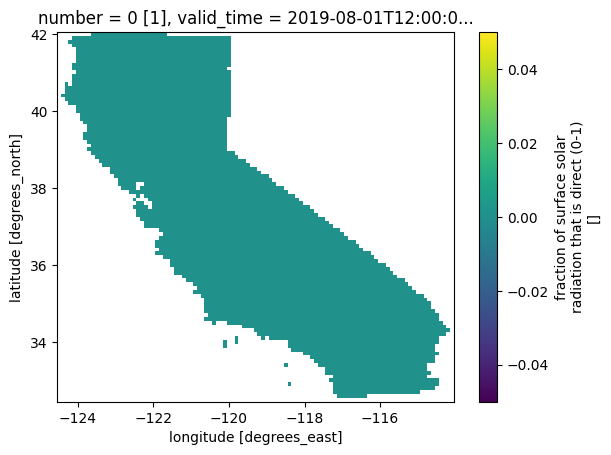

In [18]:
ds_work["fdir"].sel(valid_time="2019-08-01T12:00").plot()

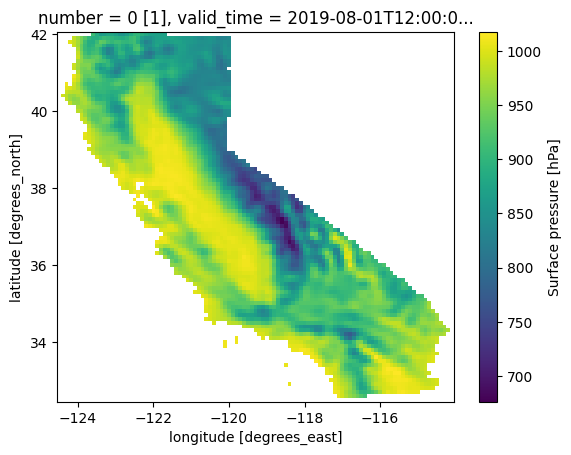

In [19]:
ds_work["pres"].sel(valid_time="2019-08-01T12:00").plot()

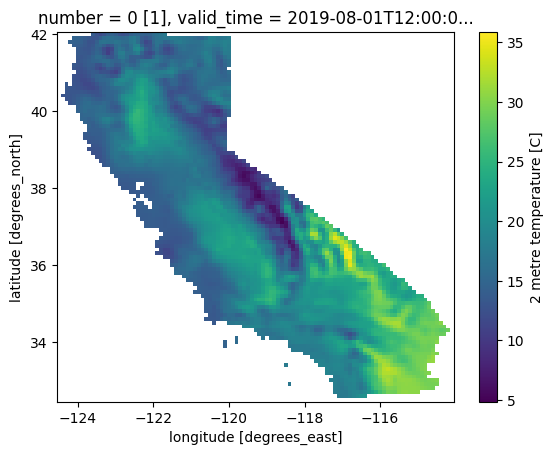

In [20]:
ds_work["Tair"].sel(valid_time="2019-08-01T12:00").plot()

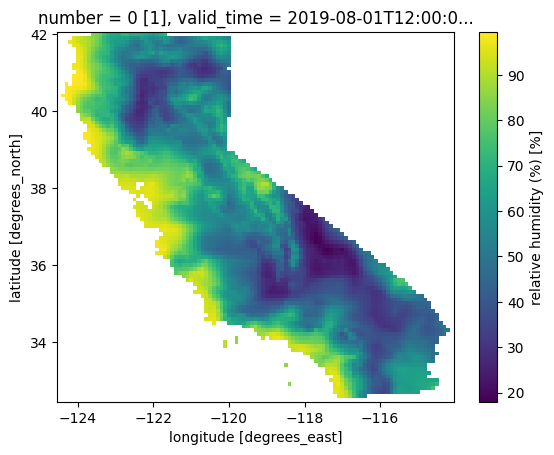

In [21]:
ds_work["relhum"].sel(valid_time="2019-08-01T12:00").plot()

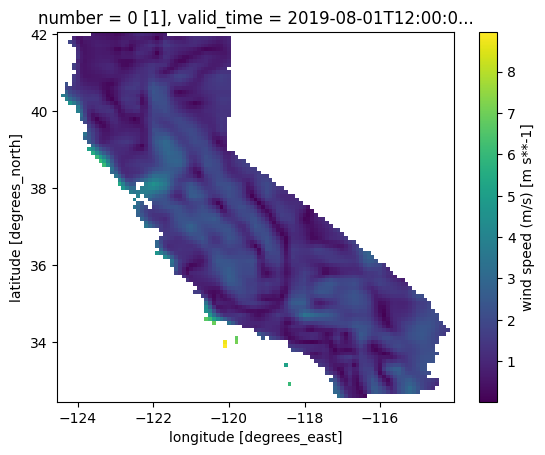

In [22]:
ds_work["speed"].sel(valid_time="2019-08-01T12:00").plot()

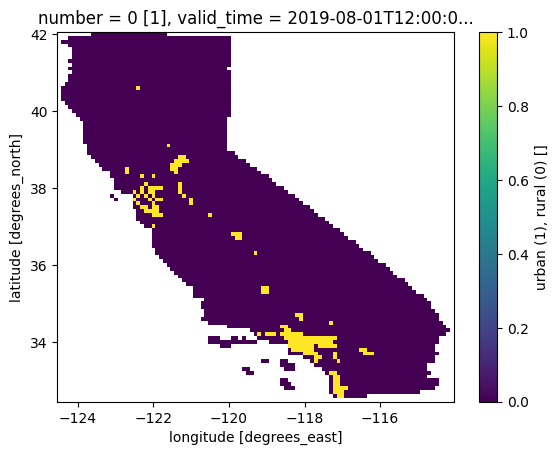

In [23]:
ds_work["urban"].sel(valid_time="2019-08-01T12:00").plot()